# Reinforcement Learning - HW 1

## by Clarice Mottet

0. **[Part 0: Set Up](#part0)**
- **Objective**: Initialize programming environment.
- **Tasks:***
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

1. **[Part 1: Policy Evaluation](#part1)**
- **Objective**: Create policies and evaluate their efficacy
- **Tasks:**
  - Lazy policy
  - Aggressive policy
  - Evaluate efficacy by directly soluving the Bellman equations

2. **[Part 2: Value Iteration and Policy Iteration](#part2)**
- **Objective**: Calculate optimal policy using value iteration and policy iteration
- **Tasks:**
  - Value iteration: create algorithm and plot
  - Policy iteration: create algorithm and plot
  - Compare value iteration and policy iteration.
  - Compare value iteration and policy iteration to the Part1 policies.

## <a id='part0'>Part 0: Set Up</a>
- **Objective**: Initialize programming environment.
- **Tasks:**
    - Set up libraries
    - Initialize global variables
    - Create functions to be used throughout notebook base on problem set up

- Set up libraries

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time


- Initialize global variables

In [157]:
N_MAX = 100
GAMMA = 0.9

Q_LOW = 0.51
Q_HIGH = 0.6

COST_LOW = 0.0
COST_HIGH = 0.01

ARRIVAL_RATE = 0.5

ACTION_LIST = [0, 1] #action_ind (low = 0, high = 1)

list_iters = [10, 20, 50, 100]


- Create functions to be used throughout notebook base on problem set up
    - reward functions
    - transition functions
    - evaluation functions
    - simulation functions

In [158]:
#reward functions

def action_cost(action_ind):
    if action_ind == 0:
        return COST_LOW
    else:
        return COST_HIGH

def reward_calc(x, action_ind):
    return -((x/N_MAX)**2) - action_cost(action_ind)

def reward_under_policy(pi):
    r_pi = np.zeros(N_MAX)
    for x in range(0, N_MAX):
        # action_ind = None
        for a in ACTION_LIST:
            r_pi[x] += reward_calc(x, a)*pi[x,a]
        #     #assuming actions are never equal
        #     if pi[x,a] > 0.5:
        #         action_ind = a
        # r_pi[x] = reward_calc(x, action_ind)
    return r_pi


In [159]:
#transitions functions

def reduction_rate(action_ind):
    if action_ind == 0:
        return Q_LOW
    else:
        return Q_HIGH
    
def transition_framework():
    #conditional matrix P(x, x_prime, a)
    P = np.zeros((N_MAX,N_MAX,2))
    for x in range(0,N_MAX):
        for a in ACTION_LIST:
            if x == 0:
                P[x, 0, a] = (1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                P[x, 1, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
            elif x == (N_MAX-1):
                P[x, N_MAX-2, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                P[x, N_MAX-1, a] = (1-reduction_rate(a)) + (reduction_rate(a))*(ARRIVAL_RATE)
            else:
                #(decrement, increment)
                for x_prime in [x-1, x, x+1]:
                    if x_prime == (x-1):
                        #(1,0)
                        P[x, x_prime, a] = (reduction_rate(a))*(1-ARRIVAL_RATE)
                    if x_prime == x:
                        #(0,0) + (1,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(1-ARRIVAL_RATE) + (reduction_rate(a))*(ARRIVAL_RATE)
                    if x_prime == (x+1):
                        #(0,1)
                        P[x, x_prime, a] = (1-reduction_rate(a))*(ARRIVAL_RATE)
    return P

def transition_under_policy(pi):
    P = transition_framework()

    #create transition matrix based on policy P(x, x_prime)
    P_pi = np.zeros((N_MAX,N_MAX))
    for x in range(N_MAX):
        for x_prime in [x-1, x, x+1]:
            if (x_prime < N_MAX) and (x_prime >= 0):
                for a in ACTION_LIST:
                    P_pi[x,x_prime] += P[x,x_prime,a]*pi[x,a]
    return P_pi


In [160]:
#evaluation functions

def value_under_policy(pi):
    P = transition_framework()
    r = reward_under_policy(pi)

    X = np.size(P,1)
    V_pi = np.zeros((X))

    P_pi = transition_under_policy(pi)
    # V_pi = np.linalg.solve((np.eye(X) - GAMMA*P_pi),r) #solves linear system V_pi = r_pi + gamma*P_pi*V_pi
    V_pi = np.linalg.inv(np.eye(X) - GAMMA*P_pi).dot(r)
    return V_pi


In [161]:
#simulation functions

def next_state(state_val, action_ind):
    increment_t = random.choices([0, 1], weights=[1-ARRIVAL_RATE, ARRIVAL_RATE])[0]
    decrement_t = random.choices([0, 1], weights=[1-reduction_rate(action_ind), reduction_rate(action_ind)])[0]
    net_t = increment_t - decrement_t
    return min(N_MAX-1, max(state_val + net_t, 0))

def plot_results(data, x_title, y_title, title, color):
    plt.figure(figsize=(5, 3))
    plt.plot(data, linestyle = 'dotted', color = color)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title)
    plt.show()

## <a id='part1'>Part 1: Policy Evaluation</a>
- **Objective**: Create policies and evaluate their efficacy
- **Tasks:**
  - Lazy policy
  - Aggressive policy
  - Evaluate efficacy by directly soluving the Bellman equations


- Lazy policy: policy that always uses the low servive rate.

$$ \pi_{lazy}(x) = a_{low} $$

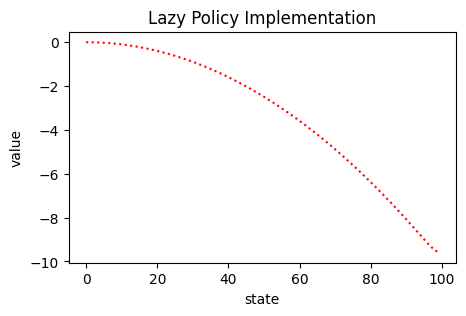

In [162]:
#lazy policy function

def policy_lazy():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        pi[x, 0] = 1 #action_ind (low = 0, high = 1)
        pi[x, 1] = 0
    return pi

#lazy policy implementation

pi_lazy = policy_lazy()
V_pi_lazy = value_under_policy(pi_lazy)

#lazy policy plot

plot_results(V_pi_lazy, 'state', 'value', 'Lazy Policy Implementation', 'red')


- Aggressive policy: policy that uses the low service rate for short queues and the high service rate for long queues

$$ \pi_{aggr}(x) = \begin{cases} a_{low}\ \text{if}\ x < 50 \\ a_{high}\ \text{otherwise}\ \end{cases} $$

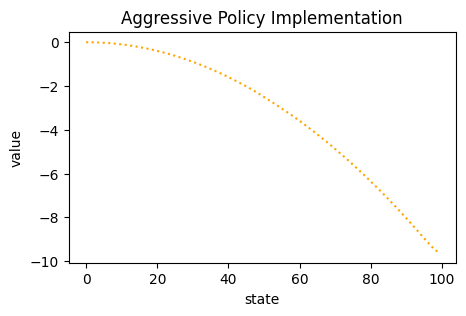

In [163]:
#aggresive policy function

def policy_aggr():
    pi = np.zeros((N_MAX,2))
    for x in range(0,N_MAX):
        if x < 50:
            pi[x, 0] = 1 #action_ind (low = 0, high = 1)
            pi[x, 1] = 0
        else:
            pi[x, 0] = 0 
            pi[x, 1] = 1 #action_ind (low = 0, high = 1)
    return pi

#aggresive policy implementation

pi_aggr = policy_aggr()
V_pi_aggr = value_under_policy(pi_aggr)

#aggresive policy plot

plot_results(V_pi_aggr, 'state', 'value', 'Aggressive Policy Implementation', 'orange')


- Compare value functions of lazy and aggressive policies.
    - Plot the difference between lazy and policy
    - Compare policy at state 50 and state 80

- Plot the difference between lazy and policy

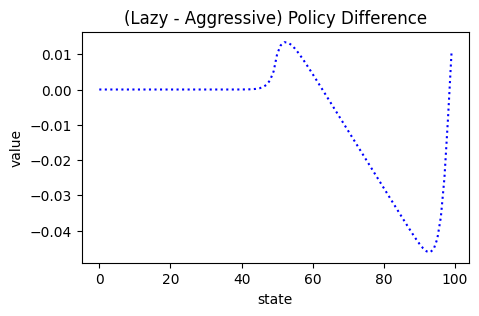

In [164]:
#plot of the difference

V_pi_diff = np.zeros(N_MAX)
for x in range(0, N_MAX):
    V_pi_diff[x] = V_pi_lazy[x] - V_pi_aggr[x]

plot_results(V_pi_diff, 'state', 'value', '(Lazy - Aggressive) Policy Difference', 'blue')


- Compare policy at state 50 and state 80

In [165]:
state = 50

print(f'At state: {state} - Lazy Value: {V_pi_lazy[state].round(4)}, Aggr Value: {V_pi_aggr[state].round(4)}, Diff: {V_pi_diff[state].round(4)}')

state = 80

print(f'At state: {state} - Lazy Value: {V_pi_lazy[state].round(4)}, Aggr Value: {V_pi_aggr[state].round(4)}, Diff: {V_pi_diff[state].round(4)}')


At state: 50 - Lazy Value: -2.4955, Aggr Value: -2.5056, Diff: 0.0101
At state: 80 - Lazy Value: -6.3901, Aggr Value: -6.3621, Diff: -0.028


## <a id='part2'>Part 2: Value Iteration and Policy Iteration</a>
- **Objective**: Calculate optimal policy using value iteration and policy iteration
- **Tasks:**
  - Value iteration: create algorithm and plot
  - Policy iteration: create algorithm and plot
  - Compare value iteration and policy iteration.
  - Compare value iteration and policy iteration to the Part1 policies.

- Value iteration: create algorithm and plot

In [166]:
def value_iteration(max_iter):
    #initialize frameworks 
    P = transition_framework()
    r = np.zeros((N_MAX, 2))
    for x in range(N_MAX):
        for a in ACTION_LIST:
            r[x,a] = reward_calc(x,a)

    #initialize value function
    V = np.zeros((N_MAX, 1))

    #value iteration
    for k in range(max_iter):
        V_star = -np.inf
        for a in range(2):
            V_star = np.maximum(V_star, r[:, a].reshape([-1, 1]) + GAMMA* P[:, :, a].dot(V))
        V = V_star
    
    return V.flatten()


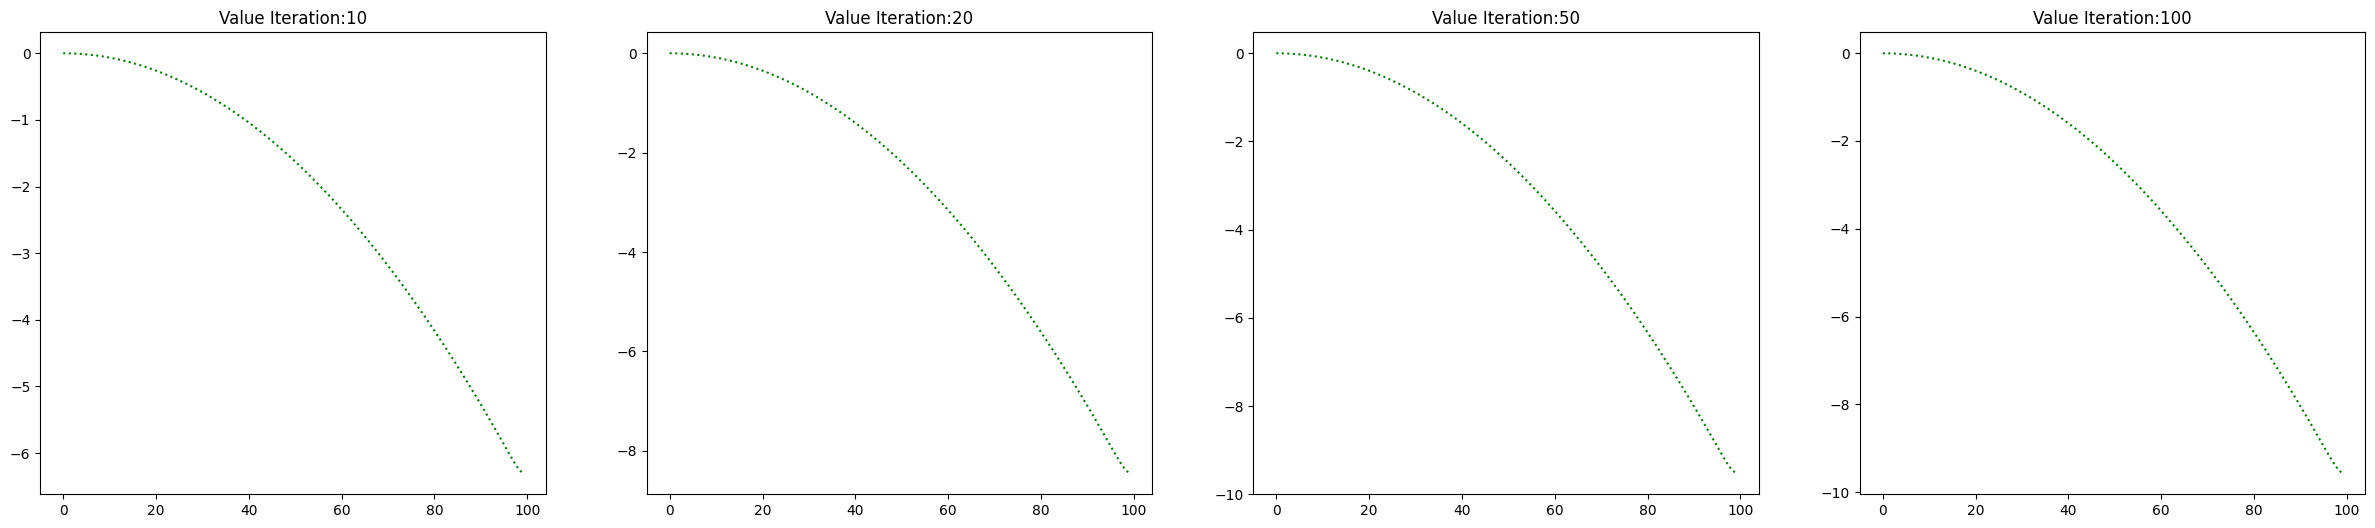

Value Iteration - Run Time for max_iter=100: 0.0102


In [167]:
#plot the value function from value iteration

fig, axes = plt.subplots(1, 4, figsize=(30, 6))

for i, ax in enumerate(axes):
    if i == 3:
        start_time = time.time()
        V_star = value_iteration(list_iters[i])
        end_time = time.time()
        run_time = round(end_time - start_time,4)
    else:
        V_star = value_iteration(list_iters[i])
    ax.plot(V_star, linestyle = 'dotted', color = 'green')
    ax.title.set_text(f'Value Iteration:{list_iters[i]}')

plt.show()

print(f'Value Iteration - Run Time for max_iter={list_iters[i]}: {run_time}')

- Policy iteration: create algorithm and plot

In [168]:
def policy_iteration(max_iter):

    #initialize frameworks
    P = transition_framework()
    pi_star = policy_aggr()

    #policy iteration
    for k in range(max_iter):

        V_new = value_under_policy(pi_star)

        V_max = np.zeros((N_MAX,2))
        for x in range(N_MAX):
            for a in ACTION_LIST:
                V_max[x,a] = reward_calc(x,a) + GAMMA*P[x, :, a].dot(V_new)

        pi_star = np.eye(V_max.shape[1])[np.argmax(V_max, axis=1)]

    return value_under_policy(pi_star), pi_star


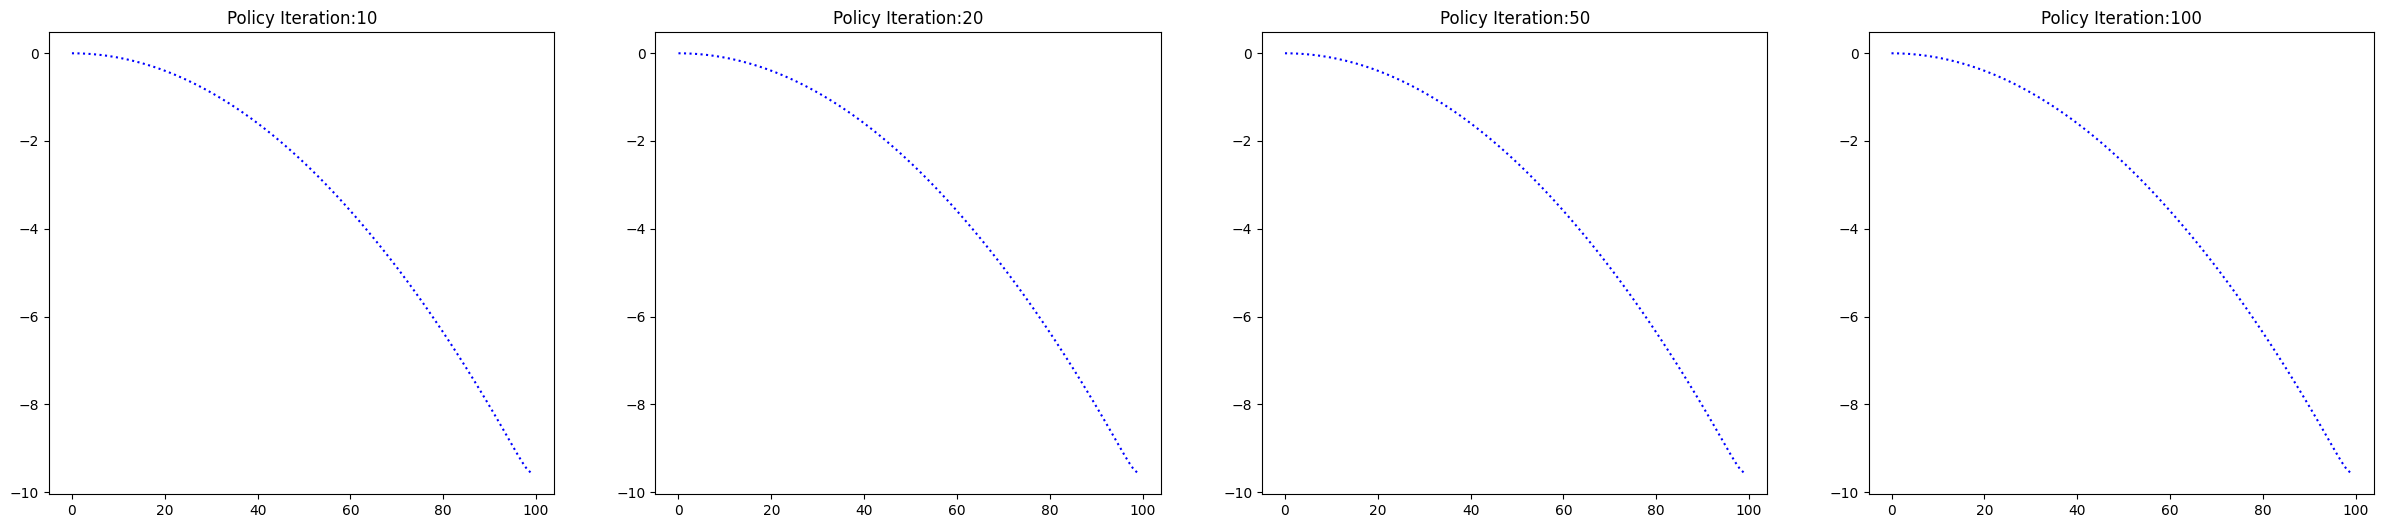

Policy Iteration - Run Time for max_iter=100: 1.1948


In [169]:
#plot the value function from policy iteration

fig, axes = plt.subplots(1, 4, figsize=(30, 6))

for i, ax in enumerate(axes):
    if i == 3:
        start_time = time.time()
        V_star, pi_star_policy = policy_iteration(list_iters[i])
        end_time = time.time()
        run_time = round(end_time - start_time,4)
    else:
        V_star, pi_star_policy = policy_iteration(list_iters[i])
    ax.plot(V_star, linestyle = 'dotted', color = 'blue')
    ax.title.set_text(f'Policy Iteration:{list_iters[i]}')

plt.show()

print(f'Policy Iteration - Run Time for max_iter={list_iters[i]}: {run_time}')

- Compare value iteration and policy iteration.

From the above print statements we see that value iteration runs much faster at 0.01 seconds while policy iteration runs slower at 1.19 seconds.

Comparing the difference of optimal value function between value iteration and policy iteration, we see that the differences decrease substatially as the number of iterations increases.

When we compare the optimal solution (those at iteration 100) to solutions from previous iterations we see that Policy Iteration more quickly converges to an optimal solution with fewer iterations needed.

If priority is a reduction in run time then value iteration would be a preferred method but may need more iterations to converge to an optimal solution, if priority is accuracy then policy iteration would be a better method to use.

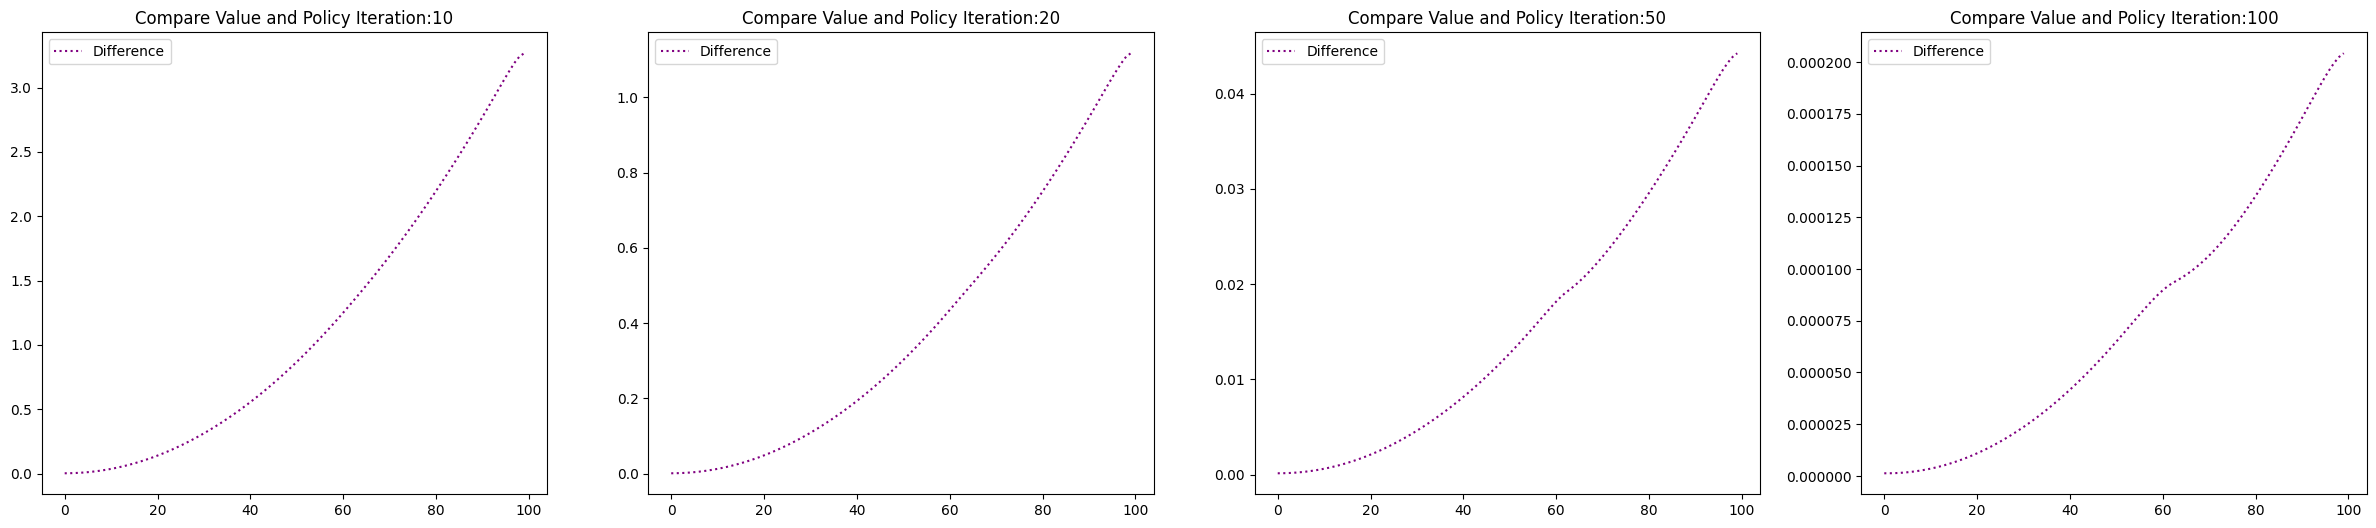

In [170]:
#plot difference between value and policy for each iteration

fig, axes = plt.subplots(1, 4, figsize=(30, 6))

for i, ax in enumerate(axes):
    V_star_value = value_iteration(list_iters[i])
    V_star_policy, pi_star_policy = policy_iteration(list_iters[i])
    V_star_diff = V_star_value - V_star_policy

    # ax.plot(V_star_value, linestyle = 'dotted', color = 'green', label = 'Value')
    # ax.plot(V_star_policy, linestyle = 'dotted', color = 'blue', label = 'Policy')
    ax.plot(V_star_diff, linestyle = 'dotted', color = 'purple', label = 'Difference')
    ax.title.set_text(f'Compare Value and Policy Iteration:{list_iters[i]}')
    ax.legend()

plt.show()

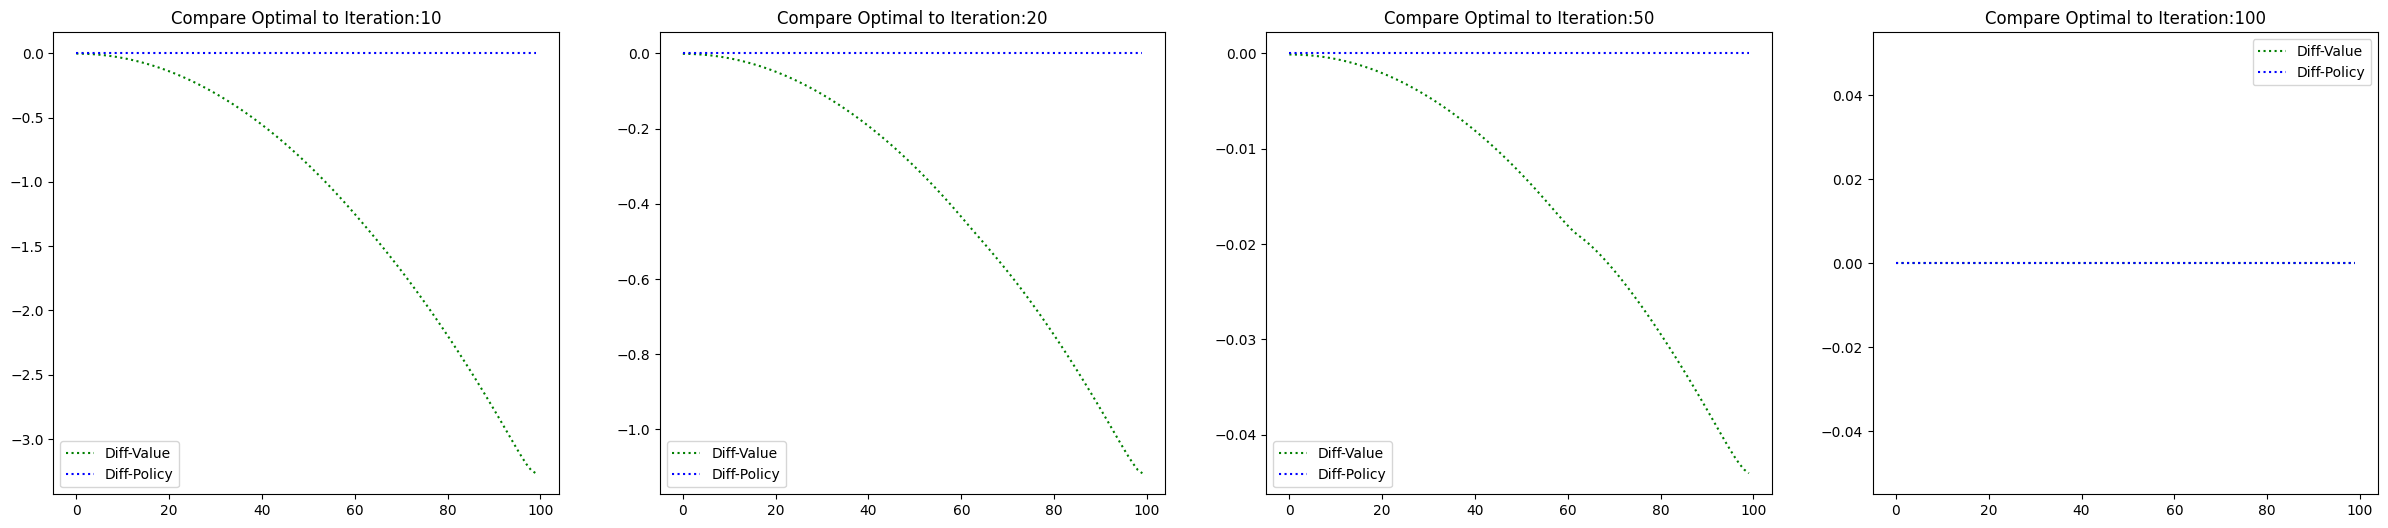

In [191]:
#compare optimal to value and policy at each iteration

fig, axes = plt.subplots(1, 4, figsize=(30, 6))

for i, ax in enumerate(axes):
    V_star_value_ = value_iteration(list_iters[i])
    V_star_policy_, pi_star_policy = policy_iteration(list_iters[i])
    V_star_diff_value = V_star_value - V_star_value_
    V_star_diff_policy = V_star_policy - V_star_policy_

    ax.plot(V_star_diff_value, linestyle = 'dotted', color = 'green', label = 'Diff-Value')
    ax.plot(V_star_diff_policy, linestyle = 'dotted', color = 'blue', label = 'Diff-Policy')
    ax.title.set_text(f'Compare Optimal to Iteration:{list_iters[i]}')
    ax.legend()

plt.show()

- Compare value iteration and policy iteration to the Part1 policies.

Comparing the resulting value functions from policies in Part 1 to the optimal value functions from value iteration and policy iteration, we see support for the notion that policy iteration converges more quickly to an optimal solution than value iterations as the differences between Part 1 are more consistent per iteration for policy iteration whereas for value iteration we see the differences grow as an optimal solution is reached with a higher number of iterations.

Optimal policy from policy iteration (iteration = 100):

$$ \pi^{*}(x) = \begin{cases} a_{low}\ \text{if}\ x < 63 \text{ or } x == 99 \\ a_{high}\ \text{otherwise}\ \end{cases} $$

Comparing this optimal policy to Part1 we see that moving the point in which we swich service levels increases the reward.

Comparing the reward differences between the Part1 policies and the optimal policy from policy iteration we see that the rewards do not differ too drastically espeacially between the optimal policy and the aggressive policy.

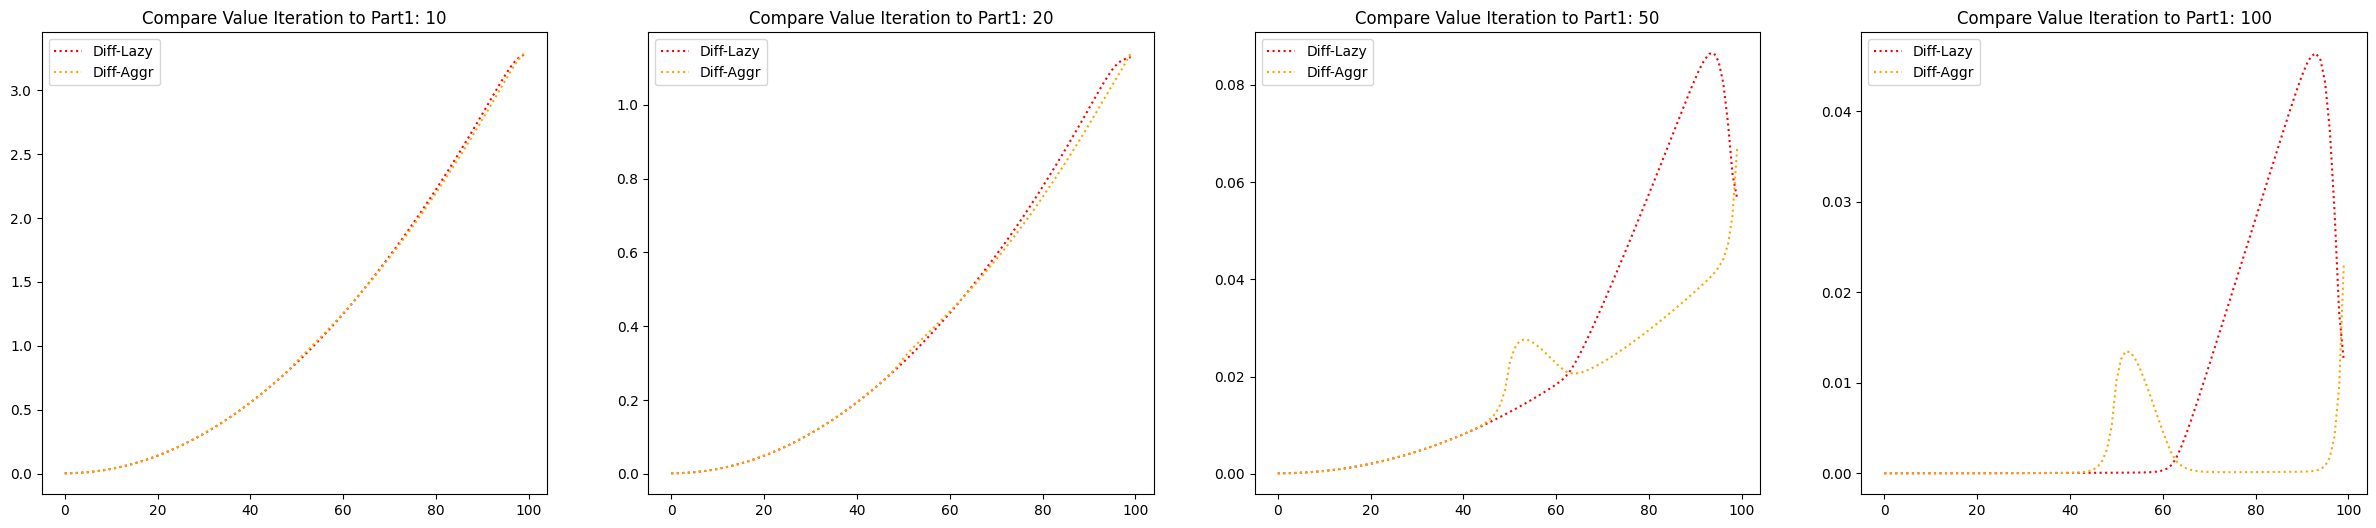

In [171]:
#Value Iteration optimal value function compared to Part1

fig, axes = plt.subplots(1, 4, figsize=(30, 6))

for i, ax in enumerate(axes):
    V_star_value = value_iteration(list_iters[i])
    V_star_diff_lazy = V_star_value - V_pi_lazy
    V_star_diff_aggr = V_star_value - V_pi_aggr

    ax.plot(V_star_diff_lazy, linestyle = 'dotted', color = 'red', label = 'Diff-Lazy')
    ax.plot(V_star_diff_aggr, linestyle = 'dotted', color = 'orange', label = 'Diff-Aggr')
    ax.title.set_text(f'Compare Value Iteration to Part1: {list_iters[i]}')
    ax.legend()

plt.show()

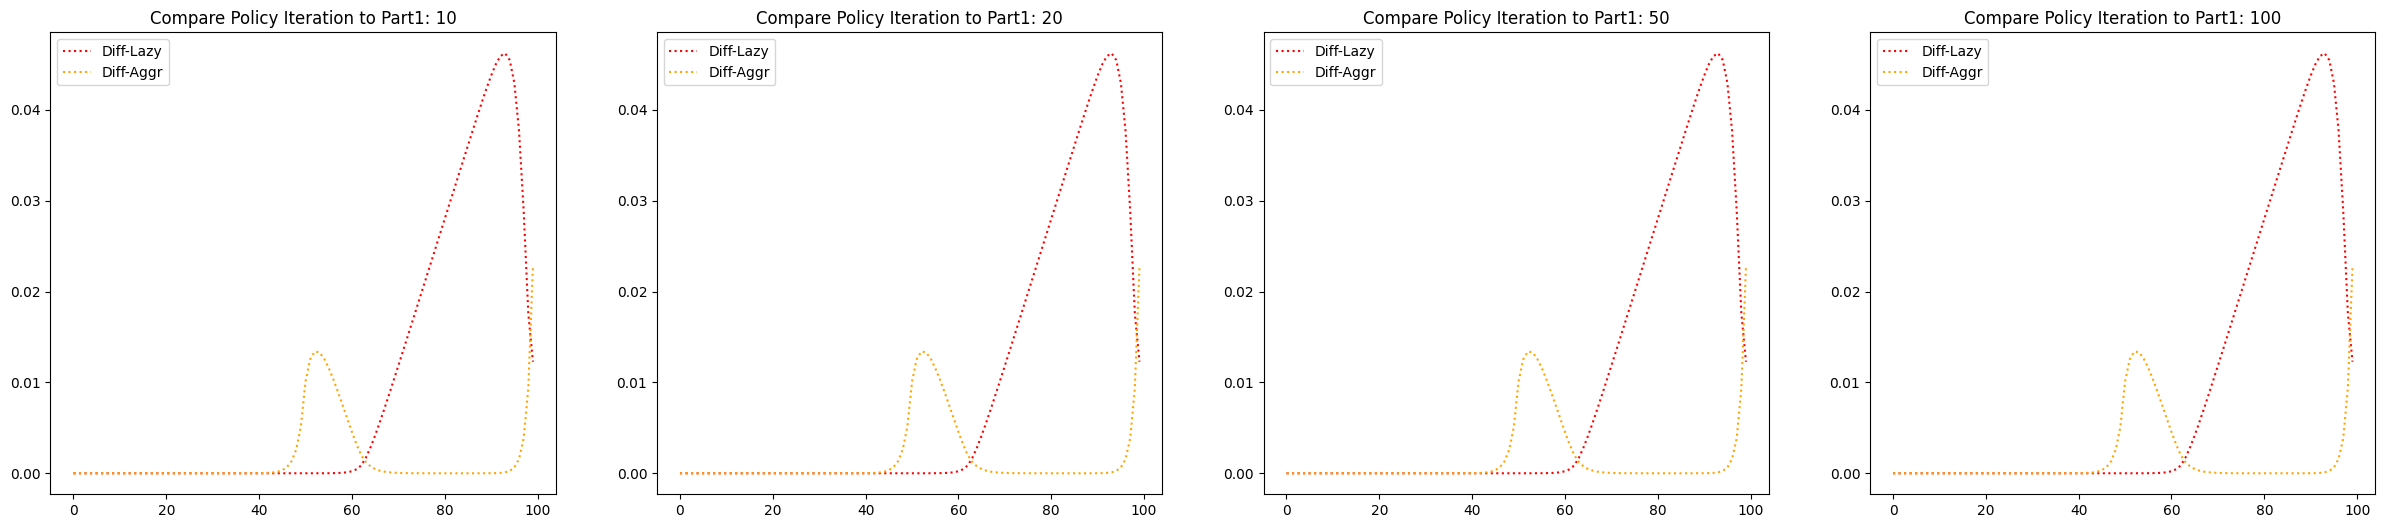

In [179]:
#Policy Iteration optimal value function compared to Part1

fig, axes = plt.subplots(1, 4, figsize=(30, 6))

for i, ax in enumerate(axes):
    V_star_policy, pi_star_policy = policy_iteration(list_iters[i])
    V_star_diff_lazy = V_star_policy - V_pi_lazy
    V_star_diff_aggr = V_star_policy - V_pi_aggr

    ax.plot(V_star_diff_lazy, linestyle = 'dotted', color = 'red', label = 'Diff-Lazy')
    ax.plot(V_star_diff_aggr, linestyle = 'dotted', color = 'orange', label = 'Diff-Aggr')
    ax.title.set_text(f'Compare Policy Iteration to Part1: {list_iters[i]}')
    ax.legend()

plt.show()

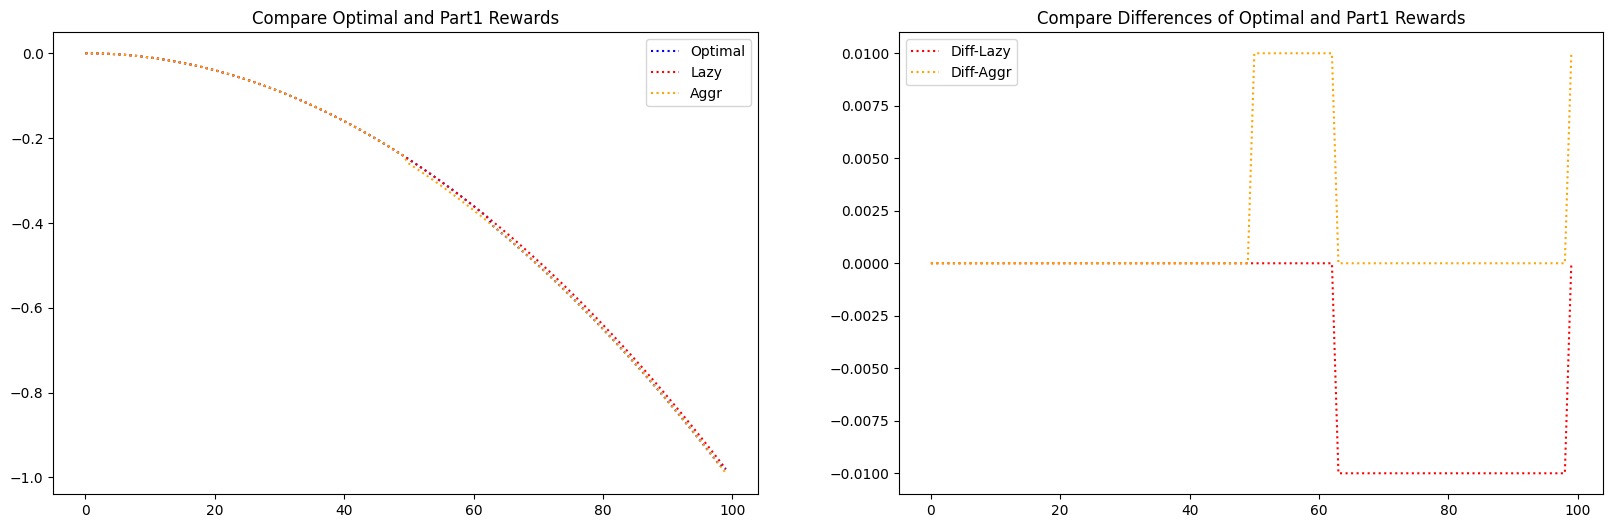

In [188]:
#reward comparison between optimal and Part1

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, ax in enumerate(axes):
    if i == 0:
        r_star = reward_under_policy(pi_star_policy)
        r_lazy = reward_under_policy(pi_lazy)
        r_aggr = reward_under_policy(pi_aggr)

        ax.plot(r_star, linestyle = 'dotted', color = 'blue', label = 'Optimal')
        ax.plot(r_lazy, linestyle = 'dotted', color = 'red', label = 'Lazy')
        ax.plot(r_aggr, linestyle = 'dotted', color = 'orange', label = 'Aggr')
        ax.title.set_text(f'Compare Optimal and Part1 Rewards')
        ax.legend()
    else:
        r_diff_lazy = r_star - r_lazy
        r_diff_aggr = r_star - r_aggr

        ax.plot(r_diff_lazy, linestyle = 'dotted', color = 'red', label = 'Diff-Lazy')
        ax.plot(r_diff_aggr, linestyle = 'dotted', color = 'orange', label = 'Diff-Aggr')
        ax.title.set_text(f'Compare Differences of Optimal and Part1 Rewards')
        ax.legend()        

plt.show()

In [190]:
#optimal policy from policy iteration (iteration = 100)

optimal_policy = np.argmax(pi_star_policy, axis=1)
count_low = 0
count_high = 0
action_str = ''
action_prev = 'x'
for x in range(N_MAX):
    if optimal_policy[x] == 0:
        action_str = "Low service rate"
        if action_str != action_prev:
            print(f"Queue at {x}: {action_str}")
        action_prev = action_str        
        count_low += 1
    else:
        action_str = "High service rate"
        if action_str != action_prev:
            print(f"Queue at {x}: {action_str}")
        action_prev = action_str        
        count_high += 1
    # print(f"Queue at {x}: {action_str}")
print(f'count_low: {count_low}, count_high: {count_high}')


Queue at 0: Low service rate
Queue at 63: High service rate
Queue at 99: Low service rate
count_low: 64, count_high: 36
